In [1]:
# %%
import numpy as np
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.tree_evaluator import TreeEvaluator

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

init_position = np.array([np.pi/2, 0])

cfg = SporeTreeConfig(
    initial_position=np.array([np.pi/2, 0.0]),
    dt_base=0.1,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)
cfg.validate()

True

In [5]:
def take_time_sign(grandchild):
    """
    Извлекает слово после последнего подчеркивания из поля 'name' каждого внука.
    Возвращает список этих слов.
    """
    
    name = grandchild['name']
    match = re.search(r'_([^_]+)$', name)
    if match.group(1) == 'forward':
        return 1
    elif match.group(1) == 'backward':
        return -1
    else:
        raise ValueError(f"Неизвестный знак времени: {match}")

# take_time_sign(grandchildren[1])

# %%

In [6]:
def draw_quad(state, time_sign,control, control_dot=0, N = 10, max_dt=0.1):
    quad_poses = [state]

    time = np.linspace(0, max_dt, N+1)
    for i in range(1,N+1):
        quad_poses.append(pendulum.quad_step(quad_poses[-1], control, 0, time_sign*time[i]))
        
    return np.array(quad_poses)

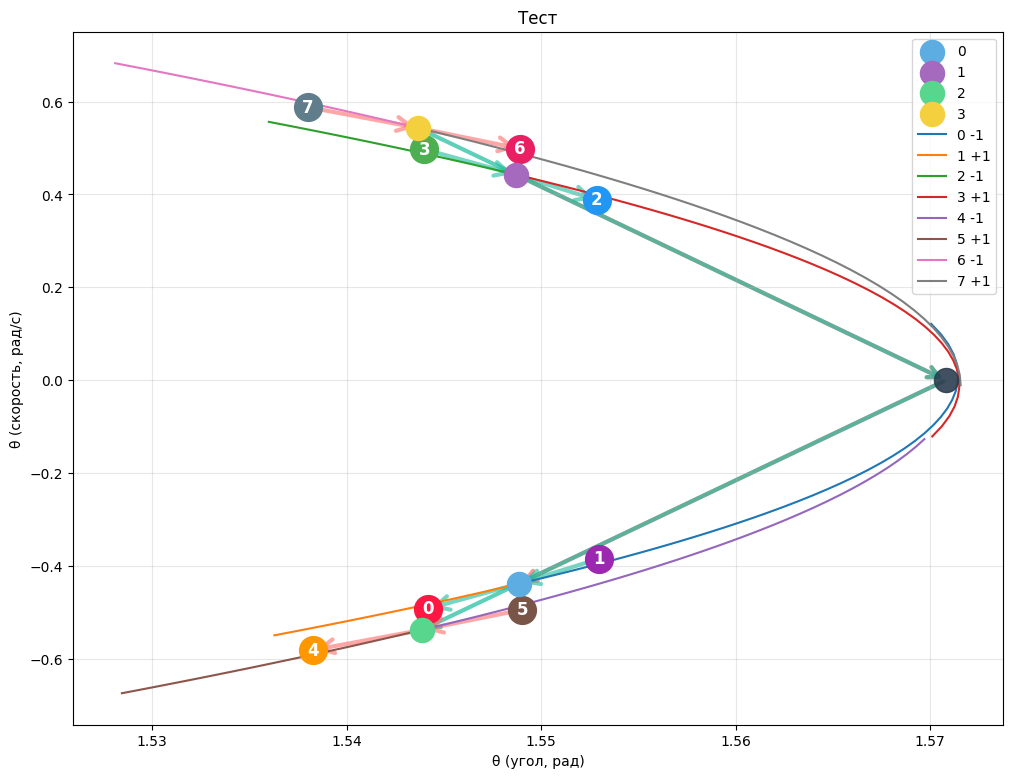

In [7]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")






dts = [0.005, 0.001, 0.001, 0.005, 0.003, 0.001, 0.001, 0.004]
for i in range(len(children)):
    poses_1 = draw_quad(state=children[i]['position'], time_sign=-1, control=children[i]['control'], N=50, max_dt=dts[2*i])
    poses_2 = draw_quad(state=children[i]['position'], time_sign=+1, control=children[i]['control'], N=50, max_dt=dts[2*i+1])
    plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{2*i} -1')
    plt.plot(poses_2[:, 0], poses_2[:, 1], label=f'{2*i+1} +1')
plt.legend()


In [166]:
def draw_rk(pendulum, state, time_sign, control, N = 50, total_dt=0.01):
    poses = [state]

    for i in range(1, N+1):
        poses.append(pendulum.step(poses[-1], control, time_sign*total_dt/N*i))

    return np.array(poses)

In [202]:
init_position = np.array([np.pi/2 * 2, 1*0])

cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.05,
    dt_grandchildren_factor=0.2,
    figure_size=(10, 10)
)
cfg.validate()

True

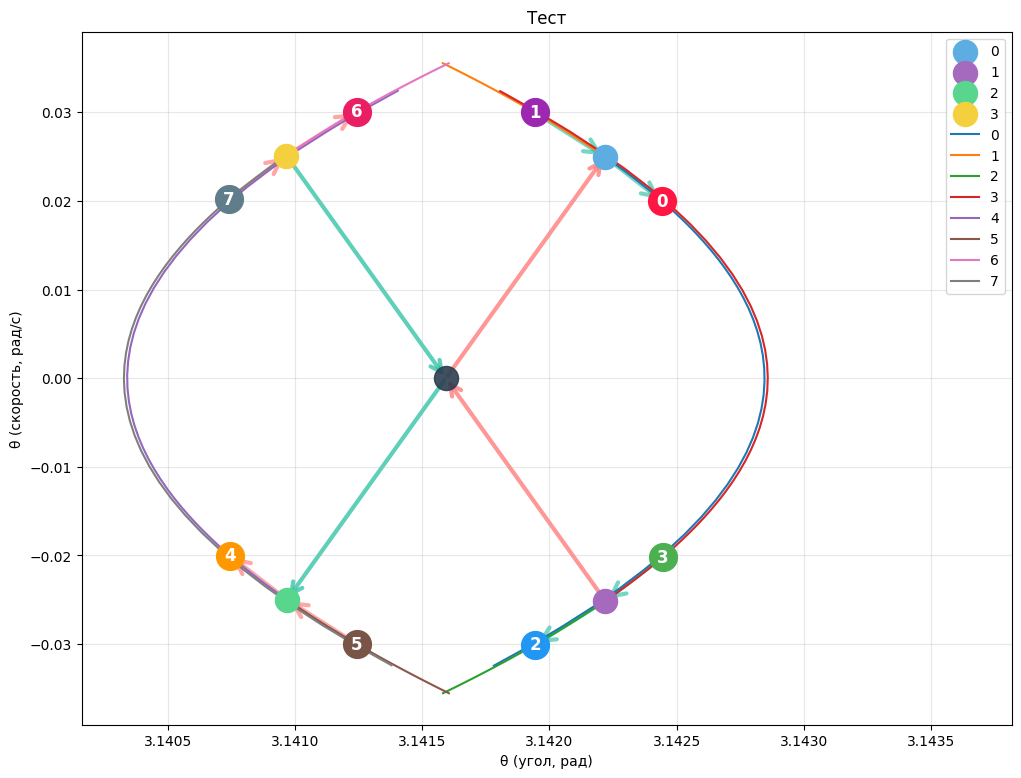

In [203]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")


poses = []
# dts = [0.01, 0.005, 0.003, 0.003, 0.01, 0.006, 0.003, 0.003]
dts = [0.0091, 0.00165, 0.00165, 0.0091, 0.0091, 0.00165, 0.00165, 0.0091]
dts = np.array(dts) * 0.5

for i in range(len(grandchildren)):
    parent_pos = children[grandchildren[i]['parent_idx']]['position']
    sign = grandchildren[i]['dt'] / grandchildren[i]['dt_abs']
    control = grandchildren[i]['control']
    poses_1 = draw_rk(pendulum, state=parent_pos, time_sign=sign, control=control, total_dt=dts[i])
    if dts[i] > 0:
        plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{i}')

plt.legend()


In [109]:
grandchildren[1]

{'position': array([1.63622608, 0.66137763]),
 'id': 'grandchild_0_1',
 'name': 'gc_0_1_backward',
 'parent_idx': 0,
 'local_idx': 1,
 'global_idx': 1,
 'control': -2.0,
 'dt': -0.020000000000000004,
 'dt_abs': 0.020000000000000004,
 'color': '#FF6B6B',
 'size': 40}

0

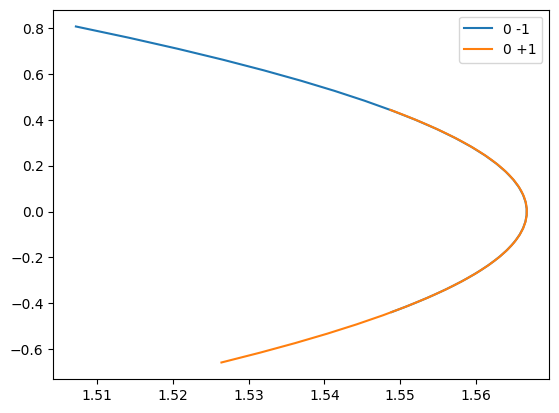

In [ ]:
plt.plot(poses[0][:, 0], poses[0][:, 1], label='0 -1')
plt.plot(poses[1][:, 0], poses[1][:, 1], label='0 +1')
plt.legend()

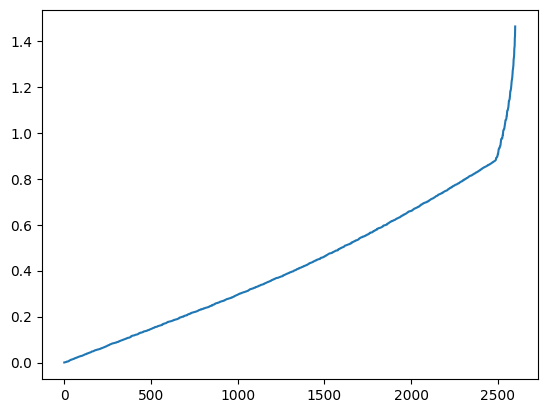

In [ ]:
p_1 = poses[0]
p_2 = poses[1]

dists = []
for i in range(len(p_1)):
    for j in range(len(p_2)):
        dist = np.linalg.norm(p_1[i] - p_2[j])
        dists.append(dist)
    
dists = np.sort(np.array(dists))

plt.plot(dists)

In [ ]:
dists[:10]

array([0.00013627, 0.00034914, 0.00084014, 0.00116462, 0.00131432,
       0.00131971, 0.00143423, 0.00161392, 0.00206813, 0.00213116])

In [ ]:
      gc_0  gc_1  gc_2  gc_3  gc_4  gc_5  gc_6  gc_7
gc_0     0     1    -1     1    -1     1     1     1
gc_1     1     0    -1     1     1     1    -1    -1
gc_2    -1    -1     0     1    -1    -1     1     1
gc_3     1     1     1     0     1     1     1    -1
gc_4    -1     1    -1     1     0     1    -1     1
gc_5     1     1    -1     1     1     0    -1     1
gc_6     1    -1     1     1    -1    -1     0     1
gc_7     1    -1     1    -1     1     1     1     0
gc_0 и gc_2 пересекутся!
gc_0 и gc_4 пересекутся!
gc_1 и gc_2 пересекутся!
gc_1 и gc_6 пересекутся!
gc_1 и gc_7 пересекутся!
gc_2 и gc_4 пересекутся!
gc_2 и gc_5 пересекутся!
gc_3 и gc_7 пересекутся!
gc_4 и gc_6 пересекутся!
gc_5 и gc_6 пересекутся!

In [ ]:
def compute_phase_acceleration_table(grandchildren, pendulum, show=False):
    """
    Анализирует фазовое ускорение внуков через третью производную маятника.
    
    Фазовое ускорение = [θ̈, θ⃛] показывает, как меняется скорость сближения/расхождения.
    
    Args:
        grandchildren: список внуков с полями 'position', 'control', 'name'
        pendulum: объект маятника
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: таблица знаков вторых производных расстояний
    """
    import numpy as np
    import pandas as pd
    import re
    
    n = len(grandchildren)
    signs_table = np.zeros((n, n), dtype=int)
    
    # Вычисляем фазовые ускорения всех внуков
    phase_accelerations = []
    for i, gc in enumerate(grandchildren):
        pos = gc['position']
        control = gc['control']
        
        # Определяем направление времени
        name = gc.get('name', '')
        match = re.search(r'_([^_]+)$', name)
        if match and match.group(1) == 'forward':
            time_sign = 1
        elif match and match.group(1) == 'backward':
            time_sign = -1
        else:
            time_sign = gc.get('time_sign', 1)
        
        # Получаем все производные
        _, theta_ddot, theta_dddot = pendulum.get_all_derivatives(pos, control)
        
        # Фазовое ускорение = [θ̈, θ⃛] с учетом направления времени
        phase_accel = time_sign * np.array([theta_ddot, theta_dddot])
        phase_accelerations.append(phase_accel)
    
    # Также вычисляем фазовые скорости для полного анализа
    phase_velocities = []
    for i, gc in enumerate(grandchildren):
        pos = gc['position']
        control = gc['control']
        
        name = gc.get('name', '')
        match = re.search(r'_([^_]+)$', name)
        time_sign = 1 if (match and match.group(1) == 'forward') else -1
        
        _, theta_ddot, _ = pendulum.get_all_derivatives(pos, control)
        phase_vel = time_sign * np.array([pos[1], theta_ddot])
        phase_velocities.append(phase_vel)
    
    # Анализируем вторую производную расстояния для всех пар
    for i in range(n):
        for j in range(n):
            if i == j:
                signs_table[i, j] = 0
            else:
                # Позиции, скорости и ускорения
                r1 = grandchildren[i]['position']
                r2 = grandchildren[j]['position']
                v1 = phase_velocities[i]
                v2 = phase_velocities[j]
                a1 = phase_accelerations[i]
                a2 = phase_accelerations[j]
                
                # Векторы разности
                r_diff = r1 - r2
                v_diff = v1 - v2
                a_diff = a1 - a2
                
                # Текущее расстояние
                distance = np.linalg.norm(r_diff)
                
                if distance < 1e-10:
                    signs_table[i, j] = 0
                else:
                    # Первая производная расстояния
                    d_dist_dt = np.dot(r_diff, v_diff) / distance
                    
                    # Вторая производная расстояния (через ускорение)
                    # d²/dt²|r₁-r₂| = [(r₁-r₂)·(a₁-a₂) + |v₁-v₂|²]/|r₁-r₂| - [(r₁-r₂)·(v₁-v₂)]²/|r₁-r₂|³
                    
                    numerator = (np.dot(r_diff, a_diff) + 
                                np.dot(v_diff, v_diff) - 
                                (d_dist_dt**2))
                    
                    d2_dist_dt2 = numerator / distance
                    
                    # Классификация по второй производной
                    if d2_dist_dt2 < -1e-6:
                        signs_table[i, j] = -1  # Ускоренное сближение
                    elif d2_dist_dt2 > 1e-6:
                        signs_table[i, j] = 1   # Ускоренное расхождение  
                    else:
                        signs_table[i, j] = 0   # Постоянная скорость изменения расстояния
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(signs_table,
                     index=[f"gc_{i}" for i in range(n)],
                     columns=[f"gc_{i}" for i in range(n)])
    
    if show:
        print("🚀 Таблица знаков ВТОРЫХ производных расстояний (фазовое ускорение):")
        print("   -1: ускоренное сближение ⇇")
        print("    0: равномерное изменение ●")
        print("   +1: ускоренное расхождение ⇉")
        print()
        print(df)
    
    return df

In [ ]:
def compute_distance_table(grandchildren, show=False):
    """
    Составляет таблицу расстояний между всеми парами внуков в фазовом пространстве.
    
    Args:
        grandchildren: список внуков с полями 'position'
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: таблица евклидовых расстояний |r_i - r_j|
    """
    import numpy as np
    import pandas as pd
    
    n = len(grandchildren)
    distance_table = np.zeros((n, n))
    
    # Вычисляем расстояния для всех пар
    for i in range(n):
        for j in range(n):
            if i == j:
                distance_table[i, j] = 0.0
            else:
                # Позиции внуков в фазовом пространстве [theta, theta_dot]
                r1 = grandchildren[i]['position']
                r2 = grandchildren[j]['position']
                
                # Евклидово расстояние в фазовом пространстве
                distance = np.linalg.norm(r1 - r2)
                distance_table[i, j] = distance
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(distance_table, 
                     index=[f"gc_{i}" for i in range(n)],
                     columns=[f"gc_{i}" for i in range(n)])
    
    if show:
        print("📏 Таблица расстояний |r_i - r_j| в фазовом пространстве:")
        print("   Евклидово расстояние между позициями [θ, θ̇]")
        print()
        # Форматируем вывод с 4 знаками после запятой
        with pd.option_context('display.precision', 4):
            print(df)
        
        # Статистика (исключаем диагональ)
        upper_triangle = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
        distances = upper_triangle.stack().values
        
        print(f"\nСтатистика расстояний:")
        print(f"  Минимальное расстояние: {distances.min():.6f}")
        print(f"  Максимальное расстояние: {distances.max():.6f}")
        print(f"  Среднее расстояние: {distances.mean():.6f}")
        print(f"  Медианное расстояние: {np.median(distances):.6f}")
        
        # Гистограмма расстояний
        print(f"\nРаспределение расстояний:")
        bins = [0, 0.5, 1.0, 2.0, 5.0, float('inf')]
        labels = ['< 0.5', '0.5-1.0', '1.0-2.0', '2.0-5.0', '> 5.0']
        
        for i, (low, high) in enumerate(zip(bins[:-1], bins[1:])):
            count = ((distances >= low) & (distances < high)).sum()
            print(f"  {labels[i]:8s}: {count:2d} пар")
    
    return df

In [ ]:
# distances = compute_distance_table(grandchildren, show=True)
velocities = compute_distance_derivative_table(grandchildren, pendulum, show=True)  
# accelerations = compute_phase_acceleration_table(grandchildren, pendulum, show=True)


📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j| (оптимизированная):
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3    gc_4    gc_5    gc_6    gc_7
gc_0   0.0000  10.7556  -0.0803  10.8070 -1.0017 -3.4341  0.9051  9.8156
gc_1  10.7556   0.0000 -10.8088   0.0962  9.7550  1.0068 -9.8199 -0.8896
gc_2  -0.0803 -10.8088   0.0000  10.9319 -1.0840 -9.7978  0.9848  9.9493
gc_3  10.8070   0.0962  10.9319   0.0000  9.7975  1.1036 -1.8149 -0.9837
gc_4  -1.0017   9.7550  -1.0840   9.7975  0.0000  8.7649 -0.0988  8.8054
gc_5  -3.4341   1.0068  -9.7978   1.1036  8.7649  0.0000 -8.8081  0.1177
gc_6   0.9051  -9.8199   0.9848  -1.8149 -0.0988 -8.8081  0.0000  8.9808
gc_7   9.8156  -0.8896   9.9493  -0.9837  8.8054  0.1177  8.9808  0.0000

Статистика:
  Сближающихся пар: 12
  Стационарных пар: 0
  Расходящихся пар: 16
  Всего уникальных пар: 28
  Максимальная скорость сближения: -10.808788
  

In [122]:
def check_trajectory_safety_elegant(pendulum, tree, gc_idx, target_dt, alien_threshold=0.15, show=False):
    """
    Элегантная проверка траектории с помощью scipy.optimize.
    Находит минимальное расстояние от траектории до каждого чужого родителя.
    
    Args:
        pendulum: объект маятника
        tree: объект дерева
        gc_idx: индекс внука
        target_dt: целевой dt
        alien_threshold: порог близости к чужому родителю
        show: краткий дебаг
        
    Returns:
        tuple: (is_safe, min_alien_distance, violating_parent_idx)
    """
    import numpy as np
    from scipy.optimize import minimize_scalar
    
    original_gc = tree.grandchildren[gc_idx]
    parent = tree.children[original_gc['parent_idx']]
    own_parent_idx = original_gc['parent_idx']
    
    # Направление времени
    name = original_gc.get('name', '')
    time_sign = 1 if 'forward' in name else -1
    
    # Создаем функцию траектории внука
    def grandchild_position(t):
        """Позиция внука в момент времени t"""
        if t <= 0:
            return parent['position']
        dt_actual = time_sign * t
        return pendulum.step(parent['position'], original_gc['control'], dt_actual)
    
    # Проверяем расстояние до каждого чужого родителя
    min_alien_distance = float('inf')
    violating_parent_idx = -1
    
    for p_idx, alien_parent in enumerate(tree.children):
        if p_idx == own_parent_idx:
            continue  # Пропускаем своего родителя
        
        # Функция расстояния от траектории до чужого родителя
        def distance_func(t):
            gc_pos = grandchild_position(t)
            return np.linalg.norm(gc_pos - alien_parent['position'])
        
        # Ищем минимальное расстояние вдоль траектории
        try:
            result = minimize_scalar(
                distance_func,
                bounds=(0, abs(target_dt)),
                method='bounded'
            )
            
            if result.success:
                min_dist_to_this_parent = result.fun
                if min_dist_to_this_parent < min_alien_distance:
                    min_alien_distance = min_dist_to_this_parent
                    if min_dist_to_this_parent < alien_threshold:
                        violating_parent_idx = p_idx
        except:
            # При ошибке считаем расстояние безопасным
            pass
    
    is_safe = min_alien_distance >= alien_threshold
    
    if show and not is_safe:
        print(f"      ❌ gc_{gc_idx}: мин. расстояние до родителя {violating_parent_idx} = {min_alien_distance:.3f} < {alien_threshold}")
    
    return is_safe, min_alien_distance, violating_parent_idx


def distance_function_elegant(dt_params, tree, pendulum, gc_i, gc_j, alien_threshold=0.15, show=False):
    """
    Элегантная функция расстояния с проверкой траекторий.
    """
    import numpy as np
    
    try:
        dt_i, dt_j = dt_params
        
        # Проверяем безопасность траекторий
        is_safe_i, min_dist_i, violating_i = check_trajectory_safety_elegant(
            pendulum, tree, gc_i, dt_i, alien_threshold, show=False
        )
        
        is_safe_j, min_dist_j, violating_j = check_trajectory_safety_elegant(
            pendulum, tree, gc_j, dt_j, alien_threshold, show=False
        )
        
        # Если траектории небезопасны - возвращаем большой штраф
        if not is_safe_i or not is_safe_j:
            if show:
                print(f"    🚫 Небезопасные траектории: gc_{gc_i}={'unsafe' if not is_safe_i else 'safe'}, gc_{gc_j}={'unsafe' if not is_safe_j else 'safe'}")
            return 1e6
        
        # Вычисляем финальные позиции и расстояние
        original_gc_i = tree.grandchildren[gc_i]
        original_gc_j = tree.grandchildren[gc_j]
        
        parent_i = tree.children[original_gc_i['parent_idx']]
        parent_j = tree.children[original_gc_j['parent_idx']]
        
        # Направления времени
        time_sign_i = 1 if 'forward' in original_gc_i.get('name', '') else -1
        time_sign_j = 1 if 'forward' in original_gc_j.get('name', '') else -1
        
        pos_i = pendulum.step(parent_i['position'], original_gc_i['control'], time_sign_i * dt_i)
        pos_j = pendulum.step(parent_j['position'], original_gc_j['control'], time_sign_j * dt_j)
        
        distance = np.linalg.norm(pos_i - pos_j)
        
        if show:
            print(f"    ✅ Безопасные траектории, расстояние: {distance:.6f}")
        
        return distance
        
    except Exception as e:
        if show:
            print(f"    ❌ Ошибка: {e}")
        return 1e6


def find_best_partners_elegant(velocity_df, tree, pendulum, alien_threshold=0.15, show=False):
    """
    Элегантный поиск лучших партнеров с минимальным дебагом.
    """
    import numpy as np
    import pandas as pd
    from scipy.optimize import minimize
    
    n = len(velocity_df)
    best_partners = {}
    
    if show:
        print(f"🔍 Поиск партнеров (порог к чужим родителям: {alien_threshold})")
    
    for gc_i in range(n):
        if show:
            print(f"\n👤 gc_{gc_i}:")
        
        best_distance = float('inf')
        best_partner_info = None
        
        for gc_j in range(n):
            if gc_i == gc_j:
                continue
                
            # Проверяем скорость сближения
            velocity = velocity_df.iloc[gc_i, gc_j]
            if velocity >= -1e-6:
                continue
            
            if show:
                print(f"  Партнер gc_{gc_j} (скорость: {velocity:.3f})")
            
            # Обертка для distance_function
            def objective_func(dt_params):
                return distance_function_elegant(
                    dt_params, tree, pendulum, gc_i, gc_j, alien_threshold, show=False
                )
            
            # Оптимизация
            min_dt = 0.001
            x0 = [min_dt, min_dt]
            bounds = [(0.0001, 0.1), (0.0001, 0.1)]
            
            try:
                result = minimize(
                    objective_func,
                    x0=x0,
                    bounds=bounds,
                    method='L-BFGS-B',
                    options={'ftol': 1e-9}
                )
                
                if result.success and result.fun < 1e5:  # Исключаем штрафы
                    if result.fun < best_distance:
                        optimal_dt_i, optimal_dt_j = result.x
                        
                        # Финальная проверка безопасности
                        is_safe_i, _, _ = check_trajectory_safety_elegant(
                            pendulum, tree, gc_i, optimal_dt_i, alien_threshold, show=False
                        )
                        is_safe_j, _, _ = check_trajectory_safety_elegant(
                            pendulum, tree, gc_j, optimal_dt_j, alien_threshold, show=False
                        )
                        
                        is_safe = is_safe_i and is_safe_j
                        
                        best_distance = result.fun
                        best_partner_info = {
                            'partner': gc_j,
                            'initial_velocity': velocity,
                            'min_distance': best_distance,
                            'optimal_dt_self': optimal_dt_i,
                            'optimal_dt_partner': optimal_dt_j,
                            'dt_change_self': optimal_dt_i / min_dt,
                            'dt_change_partner': optimal_dt_j / min_dt,
                            'is_safe': is_safe,
                            'iterations': result.nit
                        }
                        
                        status = "✅" if is_safe else "⚠️"
                        if show:
                            print(f"    {status} Лучший: {best_distance:.6f}, dt: {optimal_dt_i:.3f}, {optimal_dt_j:.3f}")
                elif show:
                    print(f"    ❌ Отвергнут (небезопасная траектория)")
                    
            except Exception as e:
                if show:
                    print(f"    ❌ Ошибка: {e}")
        
        if best_partner_info:
            best_partners[gc_i] = best_partner_info
            partner = best_partner_info['partner']
            dist = best_partner_info['min_distance']
            is_safe = best_partner_info['is_safe']
            status = "✅" if is_safe else "⚠️"
            if show:
                print(f"  {status} Лучший партнер: gc_{partner}, расстояние: {dist:.6f}")
        elif show:
            print(f"  😞 Нет подходящих партнеров")
    
    # Краткая сводка
    if show:
        print(f"\n📊 РЕЗУЛЬТАТЫ:")
        safe_pairs = sum(1 for info in best_partners.values() if info['is_safe'])
        total_pairs = len(best_partners)
        
        print(f"   Всего пар: {total_pairs}")
        print(f"   Безопасных: {safe_pairs}")
        print(f"   Небезопасных: {total_pairs - safe_pairs}")
        
        if best_partners:
            for gc_i, info in best_partners.items():
                partner = info['partner']
                dist = info['min_distance']
                status = "✅" if info['is_safe'] else "⚠️"
                dt_self = info['dt_change_self']
                dt_partner = info['dt_change_partner']
                print(f"   {status} gc_{gc_i}→gc_{partner}: {dist:.6f} (dt: x{dt_self:.1f}, x{dt_partner:.1f})")
            
            # Лучшая безопасная пара
            safe_pairs_dict = {k: v for k, v in best_partners.items() if v['is_safe']}
            if safe_pairs_dict:
                best_safe = min(safe_pairs_dict.items(), key=lambda x: x[1]['min_distance'])
                gc_i, info = best_safe
                print(f"\n🏆 ЛУЧШАЯ БЕЗОПАСНАЯ ПАРА: gc_{gc_i} ↔ gc_{info['partner']}")
                print(f"   Расстояние: {info['min_distance']:.8f}")
                print(f"   dt: {info['optimal_dt_self']:.6f}, {info['optimal_dt_partner']:.6f}")
            else:
                print(f"\n⚠️  НЕТ БЕЗОПАСНЫХ ПАР (попробуйте увеличить порог)")
    
    return best_partners

In [123]:
# %%
# Элегантный тест фильтра траекторий
print("🎯 ЭЛЕГАНТНЫЙ ФИЛЬТР ТРАЕКТОРИЙ")
print("=" * 50)

# НАСТРОЙКИ
alien_threshold = 0.001  # ← ЗАДАЙТЕ ПОРОГ

print(f"⚙️  Порог близости к чужому родителю: {alien_threshold}")

# Вычисляем таблицу скоростей сближения
velocity_df = compute_distance_derivative_table(tree.grandchildren, pendulum, show=False)

print(f"📊 Найдено {len(velocity_df)} внуков")

# Поиск лучших партнеров
best_partners = find_best_partners_elegant(
    velocity_df=velocity_df, 
    tree=tree, 
    pendulum=pendulum,
    alien_threshold=alien_threshold,
    show=True
)

🎯 ЭЛЕГАНТНЫЙ ФИЛЬТР ТРАЕКТОРИЙ
⚙️  Порог близости к чужому родителю: 0.001
📊 Найдено 8 внуков
🔍 Поиск партнеров (порог к чужим родителям: 0.001)

👤 gc_0:
  Партнер gc_2 (скорость: -0.263)
    ✅ Лучший: 0.358402, dt: 0.000, 0.100
  Партнер gc_4 (скорость: -0.995)
    ✅ Лучший: 0.009921, dt: 0.100, 0.100
  ✅ Лучший партнер: gc_4, расстояние: 0.009921

👤 gc_1:
  Партнер gc_2 (скорость: -11.145)
    ✅ Лучший: 0.035624, dt: 0.100, 0.065
  Партнер gc_6 (скорость: -10.211)
    ✅ Лучший: 0.009469, dt: 0.100, 0.099
  Партнер gc_7 (скорость: -0.710)
  ✅ Лучший партнер: gc_6, расстояние: 0.009469

👤 gc_2:
  Партнер gc_0 (скорость: -0.263)
    ✅ Лучший: 0.358402, dt: 0.100, 0.000
  Партнер gc_1 (скорость: -11.145)
    ✅ Лучший: 0.035624, dt: 0.065, 0.100
  Партнер gc_4 (скорость: -1.247)
  Партнер gc_5 (скорость: -10.143)
    ✅ Лучший: 0.010054, dt: 0.100, 0.100
  ✅ Лучший партнер: gc_5, расстояние: 0.010054

👤 gc_3:
  Партнер gc_7 (скорость: -0.987)
    ✅ Лучший: 0.000001, dt: 0.077, 0.072
  ✅ Лу

In [177]:
def pair_grandchildren_optimized(velocity_df, tree, pendulum, 
                                 safety_threshold=0.0001, 
                                 max_pairs=4, 
                                 show=True):
    """
    Находит оптимальные пары внуков на основе comprehensive анализа.
    
    Args:
        velocity_df: таблица производных расстояний
        tree: дерево спор
        pendulum: система маятника
        safety_threshold: порог безопасности для расстояния до чужих родителей
        max_pairs: максимальное количество пар (по умолчанию 4)
        show: показывать отладочную информацию
        
    Returns:
        dict: {
            'optimal_pairs': список выбранных пар,
            'rejected_pairs': список отвергнутых пар,
            'pairing_summary': сводка результатов,
            'optimal_dt_vector': вектор оптимальных dt [4 детей + 8 внуков]
        }
    """
    if show:
        print("ОПТИМАЛЬНЫЙ СПАРИВАТЕЛЬ ВНУКОВ")
        print("=" * 50)
        print(f"Порог безопасности: {safety_threshold}")
        print(f"Максимум пар: {max_pairs}")
    
    # 0. Показываем таблицу производных расстояний
    if show:
        print("\nТАБЛИЦА ПРОИЗВОДНЫХ РАССТОЯНИЙ:")
        print("=" * 40)
        print("Формат: < 0 = сближаются, > 0 = расходятся")
        print("\nПолная таблица velocity_df:")
        print(velocity_df.round(3))
        
        # Список всех сближающихся пар
        print("\nСПИСОК ВСЕХ СБЛИЖАЮЩИХСЯ ПАР:")
        n = len(velocity_df)
        converging_count = 0
        for i in range(n):
            for j in range(i + 1, n):
                vel_ij = velocity_df.iloc[i, j]
                vel_ji = velocity_df.iloc[j, i]
                if vel_ij < -1e-6 or vel_ji < -1e-6:
                    converging_count += 1
                    print(f"  Пара {converging_count}: gc_{i} <-> gc_{j}")
                    print(f"    velocity[{i},{j}] = {vel_ij:.6f}")
                    print(f"    velocity[{j},{i}] = {vel_ji:.6f}")
                    print(f"    Скорость сближения: {min(vel_ij, vel_ji):.6f}")
    
    # 1. Получаем полный анализ всех пар
    if show:
        print(f"\nДЕТАЛЬНЫЙ АНАЛИЗ КАЖДОЙ ПАРЫ:")
        print("=" * 40)
    
    detailed_results = analyze_all_converging_pairs(
        velocity_df, tree, pendulum, show=show
    )
    
    if not detailed_results:
        return {
            'optimal_pairs': [],
            'rejected_pairs': [],
            'pairing_summary': "Нет сближающихся пар",
            'optimal_dt_vector': None
        }
    
    # 2. Показываем все результаты перед фильтрацией
    if show:
        print(f"\nВСЕ ПРОАНАЛИЗИРОВАННЫЕ ПАРЫ:")
        print("=" * 40)
        for i, result in enumerate(detailed_results):
            gc_i, gc_j = result['gc_i'], result['gc_j']
            dist = result['min_distance_between']
            alien_i = result['min_alien_distance_i']
            alien_j = result['min_alien_distance_j']
            
            print(f"Пара {i+1}: gc_{gc_i} <-> gc_{gc_j}")
            print(f"  Мин. расстояние между внуками: {dist:.6f}")
            print(f"  Расстояния до чужих родителей:")
            print(f"    gc_{gc_i}: {alien_i:.6f}")
            print(f"    gc_{gc_j}: {alien_j:.6f}")
            
            # Проверка безопасности
            is_safe_i = alien_i >= safety_threshold
            is_safe_j = alien_j >= safety_threshold
            is_safe = is_safe_i and is_safe_j
            
            print(f"  Безопасность (порог {safety_threshold}):")
            print(f"    gc_{gc_i}: {'БЕЗОПАСЕН' if is_safe_i else 'ОПАСЕН'}")
            print(f"    gc_{gc_j}: {'БЕЗОПАСЕН' if is_safe_j else 'ОПАСЕН'}")
            print(f"    Общий статус: {'БЕЗОПАСНАЯ ПАРА' if is_safe else 'НЕБЕЗОПАСНАЯ ПАРА'}")
            print()
    
    # 3. Фильтруем безопасные пары
    safe_pairs = []
    unsafe_pairs = []
    
    for result in detailed_results:
        gc_i = result['gc_i']
        gc_j = result['gc_j']
        alien_dist_i = result['min_alien_distance_i']
        alien_dist_j = result['min_alien_distance_j']
        
        # Проверяем безопасность обоих внуков
        is_safe = (alien_dist_i >= safety_threshold and 
                  alien_dist_j >= safety_threshold)
        
        if is_safe:
            safe_pairs.append(result)
        else:
            unsafe_pairs.append(result)
    
    if show:
        print(f"РЕЗУЛЬТАТЫ ФИЛЬТРАЦИИ ПО БЕЗОПАСНОСТИ:")
        print(f"  Безопасных пар: {len(safe_pairs)}")
        print(f"  Небезопасных пар: {len(unsafe_pairs)}")
        
        if safe_pairs:
            print(f"\nБЕЗОПАСНЫЕ ПАРЫ (отсортированы по качеству пересечения):")
            safe_pairs_sorted = sorted(safe_pairs, key=lambda x: x['min_distance_between'])
            for i, pair in enumerate(safe_pairs_sorted):
                gc_i, gc_j = pair['gc_i'], pair['gc_j']
                dist = pair['min_distance_between']
                print(f"  {i+1}. gc_{gc_i} <-> gc_{gc_j}: {dist:.6f}")
    
    # 4. Сортируем безопасные пары по качеству пересечения
    safe_pairs.sort(key=lambda x: x['min_distance_between'])
    
    # 5. Выбираем непересекающиеся пары (каждый внук только в одной паре)
    if show:
        print(f"\nВЫБОР НЕПЕРЕСЕКАЮЩИХСЯ ПАР:")
        print("Алгоритм: берем лучшую пару, исключаем использованных внуков, повторяем")
    
    selected_pairs = []
    used_grandchildren = set()
    
    for i, pair in enumerate(safe_pairs):
        gc_i = pair['gc_i']
        gc_j = pair['gc_j']
        
        if show:
            print(f"\nШаг {i+1}: Рассматриваем пару gc_{gc_i} <-> gc_{gc_j}")
            print(f"  Расстояние: {pair['min_distance_between']:.6f}")
            print(f"  gc_{gc_i} уже использован: {'ДА' if gc_i in used_grandchildren else 'НЕТ'}")
            print(f"  gc_{gc_j} уже использован: {'ДА' if gc_j in used_grandchildren else 'НЕТ'}")
        
        # Проверяем, что оба внука еще не использованы
        if gc_i not in used_grandchildren and gc_j not in used_grandchildren:
            selected_pairs.append(pair)
            used_grandchildren.add(gc_i)
            used_grandchildren.add(gc_j)
            
            if show:
                print(f"  РЕЗУЛЬТАТ: ПАРА ПРИНЯТА (#{len(selected_pairs)})")
                print(f"  Использованные внуки: {sorted(used_grandchildren)}")
            
            if len(selected_pairs) >= max_pairs:
                if show:
                    print(f"  Достигнут лимит пар ({max_pairs}), останавливаемся")
                break
        else:
            if show:
                print(f"  РЕЗУЛЬТАТ: ПАРА ОТВЕРГНУТА (конфликт)")
    
    if show:
        print(f"\nФИНАЛЬНЫЕ ВЫБРАННЫЕ ПАРЫ:")
        for i, pair in enumerate(selected_pairs):
            gc_i, gc_j = pair['gc_i'], pair['gc_j']
            dist = pair['min_distance_between']
            print(f"  {i+1}. gc_{gc_i} <-> gc_{gc_j}: {dist:.6f}")
    
    # 6. Создаем вектор оптимальных dt
    optimal_dt_vector = None
    if selected_pairs:
        optimal_dt_vector = create_optimal_dt_vector(
            selected_pairs, tree, show=False
        )
    
    # 7. Отвергнутые пары (безопасные, но не выбранные + небезопасные)
    rejected_pairs = []
    
    # Добавляем безопасные пары, которые не вошли в финальный список
    for pair in safe_pairs:
        if pair not in selected_pairs:
            rejected_pairs.append({
                **pair,
                'rejection_reason': 'Конфликт с лучшей парой'
            })
    
    # Добавляем небезопасные пары
    for pair in unsafe_pairs:
        rejected_pairs.append({
            **pair,
            'rejection_reason': f'Нарушение порога {safety_threshold}'
        })
    
    # 8. Формируем сводку
    pairing_summary = create_pairing_summary(
        selected_pairs, rejected_pairs, safety_threshold, show=show
    )
    
    return {
        'optimal_pairs': selected_pairs,
        'rejected_pairs': rejected_pairs,
        'pairing_summary': pairing_summary,
        'optimal_dt_vector': optimal_dt_vector,
        'safety_threshold': safety_threshold,
        'total_analyzed': len(detailed_results)
    }


def create_optimal_dt_vector(selected_pairs, tree, show=True):
    """
    Создает оптимальный вектор dt [4 детей + 8 внуков] на основе выбранных пар.
    
    Args:
        selected_pairs: список выбранных пар
        tree: объект SporeTree или dict с grandchildren
        show: показывать отладочную информацию
        
    Returns:
        np.array: вектор из 12 dt значений
    """
    import numpy as np
    
    if show:
        print(f"\n🔧 Создание оптимального вектора dt...")
    
    # Получаем список внуков в зависимости от типа tree
    if hasattr(tree, 'grandchildren'):
        grandchildren = tree.grandchildren  # SporeTree объект
    else:
        grandchildren = tree['grandchildren']  # dict из build_simple_tree
    
    # Базовые dt (стандартные значения как fallback)
    dt_children = np.ones(4) * 0.01  # Стандартный dt для детей
    dt_grandchildren = np.ones(8) * 0.001  # Минимальный dt для внуков
    
    # Обновляем dt на основе оптимальных значений из пар
    for pair in selected_pairs:
        gc_i = pair['gc_i']
        gc_j = pair['gc_j']
        dt_i = pair['optimal_dt_i']
        dt_j = pair['optimal_dt_j']
        
        # Обновляем dt для внуков
        dt_grandchildren[gc_i] = dt_i
        dt_grandchildren[gc_j] = dt_j
        
        if show:
            print(f"   📊 Пара gc_{gc_i}↔gc_{gc_j}: dt={dt_i:.6f}, {dt_j:.6f}")
    
    # Обновляем dt родителей на основе их внуков
    for parent_idx in range(4):
        # Находим внуков этого родителя
        parent_grandchildren = [
            gc for gc in grandchildren 
            if gc['parent_idx'] == parent_idx
        ]
        
        if parent_grandchildren:
            # Используем максимальный dt среди внуков этого родителя
            parent_dt = max(
                dt_grandchildren[gc['global_idx']] 
                for gc in parent_grandchildren
            )
            dt_children[parent_idx] = parent_dt * 10  # Увеличиваем для родителя
            
            if show:
                gc_dts = [dt_grandchildren[gc['global_idx']] for gc in parent_grandchildren]
                print(f"   👨‍👩‍👧‍👦 Родитель {parent_idx}: dt={parent_dt*10:.6f} (внуки: {gc_dts})")
    
    # Объединяем в финальный вектор
    optimal_vector = np.concatenate([dt_children, dt_grandchildren])
    
    if show:
        print(f"✅ Создан вектор dt длиной {len(optimal_vector)}")
    
    return optimal_vector


def create_pairing_summary(selected_pairs, rejected_pairs, threshold, show=True):
    """
    Создает детальную сводку результатов спаривания.
    """
    summary = []
    
    if show:
        print(f"\n📋 СВОДКА СПАРИВАНИЯ:")
        print("=" * 60)
    
    # Выбранные пары
    if selected_pairs:
        if show:
            print(f"✅ ВЫБРАННЫЕ ПАРЫ ({len(selected_pairs)}):")
        
        for i, pair in enumerate(selected_pairs):
            gc_i, gc_j = pair['gc_i'], pair['gc_j']
            distance = pair['min_distance_between']
            alien_i = pair['min_alien_distance_i']
            alien_j = pair['min_alien_distance_j']
            
            summary.append(f"Пара {i+1}: gc_{gc_i}↔gc_{gc_j}, расст={distance:.6f}")
            
            if show:
                print(f"   🎯 Пара {i+1}: gc_{gc_i} ↔ gc_{gc_j}")
                print(f"      💫 Расстояние между внуками: {distance:.6f}")
                print(f"      🛡️  Безопасность: {alien_i:.4f}, {alien_j:.4f}")
                print(f"      ⏱️  Оптимальные dt: {pair['optimal_dt_i']:.6f}, {pair['optimal_dt_j']:.6f}")
    else:
        if show:
            print("❌ НЕТ БЕЗОПАСНЫХ ПАР")
        summary.append("Нет безопасных пар")
    
    # Статистика отвергнутых
    if show:
        print(f"\n📊 ОТВЕРГНУТЫЕ ПАРЫ ({len(rejected_pairs)}):")
        
        by_reason = {}
        for pair in rejected_pairs:
            reason = pair['rejection_reason']
            by_reason[reason] = by_reason.get(reason, 0) + 1
        
        for reason, count in by_reason.items():
            print(f"   📝 {reason}: {count} пар")
        
        # Рекомендации
        print(f"\n💡 РЕКОМЕНДАЦИИ:")
        unsafe_count = sum(1 for p in rejected_pairs 
                          if 'Нарушение порога' in p['rejection_reason'])
        
        if unsafe_count > 0:
            print(f"   ⚠️  {unsafe_count} пар нарушают порог {threshold}")
            print(f"   💡 Рассмотрите снижение порога до 0.00005")
        
        if len(selected_pairs) < 4:
            print(f"   📈 Найдено только {len(selected_pairs)} из 4 возможных пар")
            print(f"   💡 Попробуйте другие начальные условия")
    
    return "\n".join(summary)


def apply_optimal_pairing(tree_obj, optimal_dt_vector, pendulum, show=True):
    """
    Применяет оптимальный вектор dt к SporeTree и пересчитывает позиции.
    
    Args:
        tree_obj: объект SporeTree
        optimal_dt_vector: вектор из 12 dt значений
        pendulum: система маятника
        show: показывать информацию
        
    Returns:
        SporeTree: обновленный объект дерева с новыми позициями
    """
    import numpy as np
    
    if show:
        print(f"\n🔄 Применение оптимального спаривания...")
        print(f"📊 Вектор dt: {len(optimal_dt_vector)} значений")
    
    # Разделяем вектор на dt детей и внуков
    dt_children = optimal_dt_vector[:4]
    dt_grandchildren = optimal_dt_vector[4:]
    
    if show:
        print(f"📊 Новые dt детей: {dt_children}")
        print(f"👶 Новые dt внуков: {dt_grandchildren}")
    
    # Создаем новый конфиг с теми же параметрами
    new_config = SporeTreeConfig(
        initial_position=tree_obj.config.initial_position.copy(),
        dt_base=tree_obj.config.dt_base,
        dt_grandchildren_factor=tree_obj.config.dt_grandchildren_factor,
        figure_size=tree_obj.config.figure_size,
        show_debug=False  # Отключаем отладку для пересчета
    )
    
    # Создаем новое дерево
    new_tree = SporeTree(pendulum, new_config)
    
    # Создаем детей с новыми dt
    new_tree.create_children(dt_children=dt_children, show=False)
    
    # Создаем внуков с новыми dt
    new_tree.create_grandchildren(dt_grandchildren=dt_grandchildren, show=False)
    
    # Выполняем сортировку и расчеты
    new_tree.sort_and_pair_grandchildren(show=False)
    new_tree.calculate_mean_points(show=False)
    
    if show:
        print(f"✅ Дерево пересчитано с оптимальными dt")
    
    return new_tree

In [186]:
# Тестируем оптимальный спариватель
print("ТЕСТ ОПТИМАЛЬНОГО СПАРИВАТЕЛЯ")
print("=" * 50)

# Предполагаем, что у нас есть:
# - velocity_df (таблица производных)
# - tree (объект SporeTree) 
# - pendulum (система маятника)

try:
    # 1. Запускаем спариватель с порогом 0.0001
    pairing_results = pair_grandchildren_optimized(
        velocity_df=velocity_df,
        tree=tree, 
        pendulum=pendulum,
        safety_threshold=0.0001,
        max_pairs=4,
        show=True
    )
    
    print(f"\nРЕЗУЛЬТАТЫ СПАРИВАНИЯ:")
    print(f"   Выбрано пар: {len(pairing_results['optimal_pairs'])}")
    print(f"   Отвергнуто пар: {len(pairing_results['rejected_pairs'])}")
    print(f"   Всего проанализировано: {pairing_results['total_analyzed']}")
    
    # 2. Если есть оптимальные пары, применяем их
    if pairing_results['optimal_pairs'] and pairing_results['optimal_dt_vector'] is not None:
        print(f"\nПрименяем оптимальные dt...")
        
        # Создаем новое дерево с оптимальными dt
        optimized_tree = apply_optimal_pairing(
            tree_obj=tree,
            optimal_dt_vector=pairing_results['optimal_dt_vector'],
            pendulum=pendulum,
            show=True
        )
        
        print(f"\nСРАВНЕНИЕ ДО/ПОСЛЕ:")
        
        # Сравниваем расстояния между парами
        for i, pair in enumerate(pairing_results['optimal_pairs']):
            gc_i, gc_j = pair['gc_i'], pair['gc_j']
            
            # Исходное расстояние
            orig_pos_i = tree.grandchildren[gc_i]['position']
            orig_pos_j = tree.grandchildren[gc_j]['position']
            orig_distance = np.linalg.norm(orig_pos_i - orig_pos_j)
            
            # Новое расстояние
            new_pos_i = optimized_tree.grandchildren[gc_i]['position']
            new_pos_j = optimized_tree.grandchildren[gc_j]['position']
            new_distance = np.linalg.norm(new_pos_i - new_pos_j)
            
            improvement = ((orig_distance - new_distance) / orig_distance * 100) if orig_distance > 0 else 0
            
            print(f"   Пара {i+1} (gc_{gc_i}↔gc_{gc_j}):")
            print(f"      До:  {orig_distance:.6f}")
            print(f"      После: {new_distance:.6f}")
            print(f"      Улучшение: {improvement:.1f}%")
        
        # Визуализируем результат используя метод SporeTree
        print(f"\nВизуализация оптимизированного дерева...")
        
        # Создаем данные для визуализации в формате, совместимом со старой функцией
        tree_data = {
            'root': {'position': optimized_tree.root['position']},
            'children': optimized_tree.children,
            'grandchildren': optimized_tree.grandchildren
        }
        
        # Если у вас есть функция visualize_tree, используем её
        try:
            visualize_tree(tree_data)
        except NameError:
            print("Функция visualize_tree не найдена. Используйте optimized_tree для дальнейшего анализа.")
        
    else:
        threshold = pairing_results['safety_threshold']
        print(f"\nНе удалось найти безопасные пары с порогом {threshold}")
        print(f"Попробуйте уменьшить порог до 0.00005 или изменить начальные условия")
    
    # 3. Дополнительная аналитика
    print(f"\nДЕТАЛЬНАЯ АНАЛИТИКА:")
    
    # Статистика по безопасности
    all_pairs = pairing_results['optimal_pairs'] + pairing_results['rejected_pairs']
    safe_count = len(pairing_results['optimal_pairs'])
    
    print(f"   Безопасность (порог {pairing_results['safety_threshold']}):")
    print(f"      Безопасных пар: {safe_count}/{len(all_pairs)} ({safe_count/len(all_pairs)*100:.1f}%)")
    
    # Лучшие отвергнутые пары
    unsafe_pairs = [p for p in pairing_results['rejected_pairs'] 
                   if 'Нарушение порога' in p['rejection_reason']]
    
    if unsafe_pairs:
        print(f"\n   ТОП-3 лучшие небезопасные пары:")
        unsafe_pairs.sort(key=lambda x: x['min_distance_between'])
        
        for i, pair in enumerate(unsafe_pairs[:3]):
            gc_i, gc_j = pair['gc_i'], pair['gc_j']
            distance = pair['min_distance_between']
            alien_i = pair['min_alien_distance_i']
            alien_j = pair['min_alien_distance_j']
            
            print(f"      {i+1}. gc_{gc_i}↔gc_{gc_j}: расст={distance:.6f}")
            print(f"         Угрозы: {alien_i:.6f}, {alien_j:.6f}")

except Exception as e:
    print(f"Ошибка в тесте: {e}")
    import traceback
    traceback.print_exc()

ТЕСТ ОПТИМАЛЬНОГО СПАРИВАТЕЛЯ
ОПТИМАЛЬНЫЙ СПАРИВАТЕЛЬ ВНУКОВ
Порог безопасности: 0.0001
Максимум пар: 4

ТАБЛИЦА ПРОИЗВОДНЫХ РАССТОЯНИЙ:
Формат: < 0 = сближаются, > 0 = расходятся

Полная таблица velocity_df:
        gc_0    gc_1    gc_2    gc_3    gc_4    gc_5    gc_6    gc_7
gc_0   0.000  10.947  -0.263  11.112  -0.995   9.819   0.706  10.154
gc_1  10.947   0.000 -11.145   0.254   9.926   1.008 -10.211  -0.710
gc_2  -0.263 -11.145   0.000  11.397  -1.247 -10.143   0.986  10.428
gc_3  11.112   0.254  11.397   0.000  10.115   1.243  10.245  -0.987
gc_4  -0.995   9.926  -1.247  10.115   0.000   8.921  -0.277   9.149
gc_5   9.819   1.008 -10.143   1.243   8.921   0.000  -9.188   0.274
gc_6   0.706 -10.211   0.986  10.245  -0.277  -9.188   0.000   9.553
gc_7  10.154  -0.710  10.428  -0.987   9.149   0.274   9.553   0.000

СПИСОК ВСЕХ СБЛИЖАЮЩИХСЯ ПАР:
  Пара 1: gc_0 <-> gc_2
    velocity[0,2] = -0.263401
    velocity[2,0] = -0.263401
    Скорость сближения: -0.263401
  Пара 2: gc_0 <-> gc

In [20]:
def compute_distance_derivative_table(grandchildren, pendulum, show=False):
    """
    Составляет оптимизированную таблицу первых производных расстояний (только верхний треугольник).
    
    Args:
        grandchildren: список внуков с полями 'position', 'control', 'name'
        pendulum: объект маятника для вычисления скоростей
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: симметричная таблица значений d/dt|r_i - r_j|
            Отрицательные: сближаются (чем меньше, тем быстрее)
            Положительные: расходятся (чем больше, тем быстрее)
    """
    import numpy as np
    import pandas as pd
    import re
    
    n = len(grandchildren)
    values_table = np.zeros((n, n))
    
    # Вычисляем скорости всех внуков с учетом направления времени
    velocities = []
    for i, gc in enumerate(grandchildren):
        pos = gc['position']
        control = gc['control']
        
        # Определяем направление времени из имени
        name = gc.get('name', '')
        match = re.search(r'_([^_]+)$', name)
        if match and match.group(1) == 'forward':
            time_sign = 1
        elif match and match.group(1) == 'backward':
            time_sign = -1
        else:
            time_sign = gc.get('time_sign', 1)
        
        # Получаем ускорение от маятника
        _, theta_ddot, _ = pendulum.get_all_derivatives(pos, control)
        
        # Скорость в фазовом пространстве с учетом направления времени
        velocity_vector = time_sign * np.array([pos[1], theta_ddot])
        velocities.append(velocity_vector)
    
    # Заполняем только верхний треугольник (оптимизация в 2 раза)
    for i in range(n):
        for j in range(i+1, n):  # Только j > i
            # Позиции и скорости
            r1 = grandchildren[i]['position']
            r2 = grandchildren[j]['position']
            v1 = velocities[i]
            v2 = velocities[j]
            
            # Вектор между точками и разность скоростей
            r_diff = r1 - r2
            v_diff = v1 - v2
            
            # Текущее расстояние
            distance = np.linalg.norm(r_diff)
            
            if distance < 1e-10:
                derivative_value = 0.0
            else:
                # Производная расстояния: d/dt |r1 - r2| = (r1-r2)·(v1-v2) / |r1-r2|
                derivative_value = np.dot(r_diff, v_diff) / distance
            
            # Заполняем симметрично
            values_table[i, j] = derivative_value
            values_table[j, i] = derivative_value
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(values_table, 
                     index=[f"gc_{i}" for i in range(n)],
                     columns=[f"gc_{i}" for i in range(n)])
    
    if show:
        print("📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j| (оптимизированная):")
        print("   < 0: сближаются (чем меньше, тем быстрее)")
        print("   = 0: стационарно") 
        print("   > 0: расходятся (чем больше, тем быстрее)")
        print()
        # Форматируем вывод с 4 знаками после запятой
        with pd.option_context('display.precision', 4):
            print(df)
        
        # Дополнительная статистика (только верхний треугольник)
        upper_triangle = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
        valid_values = upper_triangle.stack().values
        
        negative_count = (valid_values < -1e-6).sum()
        zero_count = ((valid_values >= -1e-6) & (valid_values <= 1e-6)).sum()
        positive_count = (valid_values > 1e-6).sum()
        
        print(f"\nСтатистика:")
        print(f"  Сближающихся пар: {negative_count}")
        print(f"  Стационарных пар: {zero_count}")
        print(f"  Расходящихся пар: {positive_count}")
        print(f"  Всего уникальных пар: {len(valid_values)}")
        
        if negative_count > 0:
            min_val = valid_values[valid_values < -1e-6].min()
            print(f"  Максимальная скорость сближения: {min_val:.6f}")
        if positive_count > 0:
            max_val = valid_values[valid_values > 1e-6].max()
            print(f"  Максимальная скорость расхождения: {max_val:.6f}")
    
    return df

In [37]:
def find_min_distance_to_aliens(pendulum, tree, gc_idx, dt_target):
    """
    Находит минимальное расстояние от траектории внука до всех чужих родителей.
    
    Returns:
        dict: {parent_idx: min_distance} для всех чужих родителей
    """
    import numpy as np
    from scipy.optimize import minimize_scalar
    
    original_gc = tree.grandchildren[gc_idx]
    parent = tree.children[original_gc['parent_idx']]
    own_parent_idx = original_gc['parent_idx']
    
    # Направление времени
    name = original_gc.get('name', '')
    time_sign = 1 if 'forward' in name else -1
    
    def grandchild_position(t):
        """Позиция внука в момент времени t"""
        if t <= 0:
            return parent['position']
        dt_actual = time_sign * t
        return pendulum.step(parent['position'], original_gc['control'], dt_actual)
    
    alien_distances = {}
    
    for p_idx, alien_parent in enumerate(tree.children):
        if p_idx == own_parent_idx:
            continue  # Пропускаем своего родителя
        
        def distance_func(t):
            gc_pos = grandchild_position(t)
            return np.linalg.norm(gc_pos - alien_parent['position'])
        
        try:
            result = minimize_scalar(
                distance_func,
                bounds=(0, abs(dt_target)),
                method='bounded'
            )
            
            if result.success:
                alien_distances[p_idx] = result.fun
            else:
                alien_distances[p_idx] = float('inf')
        except:
            alien_distances[p_idx] = float('inf')
    
    return alien_distances


def optimize_pair_distance(velocity_df, tree, pendulum, gc_i, gc_j):
    """
    Оптимизирует dt для минимального расстояния между парой внуков.
    
    Returns:
        dict с результатами оптимизации
    """
    import numpy as np
    from scipy.optimize import minimize
    
    def distance_function(dt_params):
        try:
            dt_i, dt_j = dt_params
            
            # Вычисляем позиции внуков
            original_gc_i = tree.grandchildren[gc_i]
            original_gc_j = tree.grandchildren[gc_j]
            
            parent_i = tree.children[original_gc_i['parent_idx']]
            parent_j = tree.children[original_gc_j['parent_idx']]
            
            # Направления времени
            time_sign_i = 1 if 'forward' in original_gc_i.get('name', '') else -1
            time_sign_j = 1 if 'forward' in original_gc_j.get('name', '') else -1
            
            pos_i = pendulum.step(parent_i['position'], original_gc_i['control'], time_sign_i * dt_i)
            pos_j = pendulum.step(parent_j['position'], original_gc_j['control'], time_sign_j * dt_j)
            
            return np.linalg.norm(pos_i - pos_j)
            
        except Exception:
            return 1e6
    
    # Оптимизация
    min_dt = 0.001
    x0 = [min_dt, min_dt]
    bounds = [(0.001, 1.0), (0.001, 1.0)]
    
    try:
        result = minimize(
            distance_function,
            x0=x0,
            bounds=bounds,
            method='L-BFGS-B',
            options={'ftol': 1e-9}
        )
        
        if result.success:
            optimal_dt_i, optimal_dt_j = result.x
            return {
                'success': True,
                'min_distance': result.fun,
                'optimal_dt_i': optimal_dt_i,
                'optimal_dt_j': optimal_dt_j,
                'dt_change_i': optimal_dt_i / min_dt,
                'dt_change_j': optimal_dt_j / min_dt,
                'iterations': result.nit,
                'initial_velocity': velocity_df.iloc[gc_i, gc_j]
            }
        else:
            return {'success': False, 'message': result.message}
    except Exception as e:
        return {'success': False, 'message': str(e)}


def analyze_all_converging_pairs(velocity_df, tree, pendulum, show=True):
    """
    Анализирует все пары с отрицательными производными (сближающиеся).
    
    Returns:
        list: детальная информация о каждой паре
    """
    import numpy as np
    import pandas as pd
    
    n = len(velocity_df)
    converging_pairs = []
    
    # Находим все пары с отрицательными производными
    if show:
        print("🔍 Поиск всех сближающихся пар...")
    
    for i in range(n):
        for j in range(i + 1, n):  # Избегаем дублирования (i,j) и (j,i)
            velocity_ij = velocity_df.iloc[i, j]
            velocity_ji = velocity_df.iloc[j, i]
            
            # Проверяем взаимное сближение
            if velocity_ij < -1e-6 or velocity_ji < -1e-6:
                converging_pairs.append((i, j, velocity_ij, velocity_ji))
    
    if show:
        print(f"✅ Найдено {len(converging_pairs)} сближающихся пар")
    
    # Анализируем каждую пару
    detailed_results = []
    
    for idx, (gc_i, gc_j, vel_ij, vel_ji) in enumerate(converging_pairs):
        if show:
            # Показываем информацию о родителях внуков
            parent_i = tree.grandchildren[gc_i]['parent_idx']
            parent_j = tree.grandchildren[gc_j]['parent_idx']
            name_i = tree.grandchildren[gc_i].get('name', f'gc_{gc_i}')
            name_j = tree.grandchildren[gc_j].get('name', f'gc_{gc_j}')
            
            print(f"\n📊 Пара {idx+1}/{len(converging_pairs)}: gc_{gc_i}({name_i}, от родителя {parent_i}) ↔ gc_{gc_j}({name_j}, от родителя {parent_j})")
        
        # Оптимизируем расстояние между внуками
        optimization_result = optimize_pair_distance(velocity_df, tree, pendulum, gc_i, gc_j)
        
        if not optimization_result['success']:
            if show:
                print(f"   ❌ Ошибка оптимизации: {optimization_result.get('message', 'unknown')}")
            continue
        
        # Находим минимальные расстояния до чужих родителей
        alien_distances_i = find_min_distance_to_aliens(
            pendulum, tree, gc_i, optimization_result['optimal_dt_i']
        )
        alien_distances_j = find_min_distance_to_aliens(
            pendulum, tree, gc_j, optimization_result['optimal_dt_j']
        )
        
        # Находим ближайших чужих родителей
        closest_alien_i = min(alien_distances_i.items(), key=lambda x: x[1]) if alien_distances_i else (None, float('inf'))
        closest_alien_j = min(alien_distances_j.items(), key=lambda x: x[1]) if alien_distances_j else (None, float('inf'))
        
        # Собираем результаты
        result = {
            'gc_i': gc_i,
            'gc_j': gc_j,
            'velocity_ij': vel_ij,
            'velocity_ji': vel_ji,
            'min_distance_between': optimization_result['min_distance'],
            'optimal_dt_i': optimization_result['optimal_dt_i'],
            'optimal_dt_j': optimization_result['optimal_dt_j'],
            'dt_change_i': optimization_result['dt_change_i'],
            'dt_change_j': optimization_result['dt_change_j'],
            'alien_distances_i': alien_distances_i,
            'alien_distances_j': alien_distances_j,
            'min_alien_distance_i': closest_alien_i[1],
            'min_alien_distance_j': closest_alien_j[1],
            'closest_alien_parent_i': closest_alien_i[0],
            'closest_alien_parent_j': closest_alien_j[0],
            'iterations': optimization_result['iterations']
        }
        
        detailed_results.append(result)
        
        if show:
            print(f"   💫 Мин. расстояние между внуками: {result['min_distance_between']:.6f}")
            print(f"   ⏱️  Оптимальные dt: {result['optimal_dt_i']:.3f}, {result['optimal_dt_j']:.3f}")
            print(f"   📈 Изменения dt: x{result['dt_change_i']:.1f}, x{result['dt_change_j']:.1f}")
            print(f"   🚫 Мин. расстояние до чужих родителей:")
            
            # Показываем ближайших чужих родителей
            if result['closest_alien_parent_i'] is not None:
                print(f"      gc_{gc_i}: {result['min_alien_distance_i']:.3f} (ближайший чужой родитель {result['closest_alien_parent_i']})")
            else:
                print(f"      gc_{gc_i}: нет чужих родителей")
                
            if result['closest_alien_parent_j'] is not None:
                print(f"      gc_{gc_j}: {result['min_alien_distance_j']:.3f} (ближайший чужой родитель {result['closest_alien_parent_j']})")
            else:
                print(f"      gc_{gc_j}: нет чужих родителей")
            
            # Качественная оценка
            if result['min_distance_between'] < 1e-6:
                print(f"   🎯 ИДЕАЛЬНОЕ ПЕРЕСЕЧЕНИЕ")
            elif result['min_distance_between'] < 1e-3:
                print(f"   ✨ Отличное пересечение")
            elif result['min_distance_between'] < 1e-2:
                print(f"   👍 Хорошее пересечение")
            else:
                print(f"   🤔 Среднее пересечение")
            
            # Предупреждения о близости к чужим родителям
            for threshold in [0.1, 0.15, 0.2]:
                violations = []
                if result['min_alien_distance_i'] < threshold:
                    violations.append(f"gc_{gc_i}→родитель {result['closest_alien_parent_i']} ({result['min_alien_distance_i']:.3f})")
                if result['min_alien_distance_j'] < threshold:
                    violations.append(f"gc_{gc_j}→родитель {result['closest_alien_parent_j']} ({result['min_alien_distance_j']:.3f})")
                
                if violations:
                    print(f"   ⚠️  НАРУШЕНИЕ порога {threshold}: {', '.join(violations)}")
                    break
    
    return detailed_results


def print_summary_table(detailed_results, show_thresholds=[0.0001, 0.005, 0.01]):
    """
    Выводит сводную таблицу результатов.
    """
    import pandas as pd
    
    if not detailed_results:
        print("😞 Нет результатов для отображения")
        return
    
    print(f"\n📋 СВОДНАЯ ТАБЛИЦА ({len(detailed_results)} пар)")
    print("=" * 120)
    print("Формат: расстояние(ближайший_чужой_родитель), например 0.12(p2) = расстояние 0.12 до родителя 2")
    
    # Заголовок таблицы
    header = "Пара      | Расст.между | dt изм.     | Мин.расст.до чужих (родитель) | Статус по порогам"
    print(header)
    print("-" * len(header))
    
    # Сортируем по минимальному расстоянию между внуками
    sorted_results = sorted(detailed_results, key=lambda x: x['min_distance_between'])
    
    for result in sorted_results:
        gc_i, gc_j = result['gc_i'], result['gc_j']
        min_dist = result['min_distance_between']
        dt_i, dt_j = result['dt_change_i'], result['dt_change_j']
        alien_i = result['min_alien_distance_i']
        alien_j = result['min_alien_distance_j']
        alien_parent_i = result['closest_alien_parent_i']
        alien_parent_j = result['closest_alien_parent_j']
        
        # Форматируем информацию о чужих родителях
        alien_info_i = f"{alien_i:.2f}(p{alien_parent_i})" if alien_parent_i is not None else f"{alien_i:.2f}(-)"
        alien_info_j = f"{alien_j:.2f}(p{alien_parent_j})" if alien_parent_j is not None else f"{alien_j:.2f}(-)"
        
        # Статус по порогам
        status_flags = []
        for threshold in show_thresholds:
            if alien_i < threshold or alien_j < threshold:
                status_flags.append(f"❌{threshold}")
            else:
                status_flags.append(f"✅{threshold}")
        
        status_str = " ".join(status_flags)
        
        print(f"gc_{gc_i:2}↔gc_{gc_j:2} | {min_dist:11.6f} | x{dt_i:3.1f}, x{dt_j:3.1f} | {alien_info_i:>8}, {alien_info_j:>8}     | {status_str}")
    
    print("=" * 120)
    
    # Статистика по порогам
    print(f"\n📊 СТАТИСТИКА ПО ПОРОГАМ:")
    for threshold in show_thresholds:
        safe_count = sum(1 for r in detailed_results 
                        if r['min_alien_distance_i'] >= threshold and r['min_alien_distance_j'] >= threshold)
        total = len(detailed_results)
        print(f"   Порог {threshold}: {safe_count}/{total} пар безопасны ({100*safe_count/total:.1f}%)")
    
    # Лучшие пары
    print(f"\n🏆 ТОП-3 ЛУЧШИЕ ПАРЫ ПО РАССТОЯНИЮ:")
    for i, result in enumerate(sorted_results[:3]):
        alien_parent_i = result['closest_alien_parent_i']
        alien_parent_j = result['closest_alien_parent_j']
        
        alien_info_i = f"{result['min_alien_distance_i']:.3f} (ближайший чужой родитель {alien_parent_i})" if alien_parent_i is not None else f"{result['min_alien_distance_i']:.3f} (нет чужих)"
        alien_info_j = f"{result['min_alien_distance_j']:.3f} (ближайший чужой родитель {alien_parent_j})" if alien_parent_j is not None else f"{result['min_alien_distance_j']:.3f} (нет чужих)"
        
        print(f"   {i+1}. gc_{result['gc_i']} ↔ gc_{result['gc_j']}: {result['min_distance_between']:.6f}")
        print(f"      gc_{result['gc_i']}: {alien_info_i}")
        print(f"      gc_{result['gc_j']}: {alien_info_j}")
        
        # Проверка безопасности для разных порогов
        safety_info = []
        for threshold in show_thresholds:
            if result['min_alien_distance_i'] >= threshold and result['min_alien_distance_j'] >= threshold:
                safety_info.append(f"✅{threshold}")
            else:
                safety_info.append(f"❌{threshold}")
        print(f"      Безопасность: {' '.join(safety_info)}")


def full_pair_analysis(velocity_df, tree, pendulum, show=True):
    """
    Полный анализ всех сближающихся пар.
    """
    print("🎯 ПОЛНЫЙ АНАЛИЗ ВСЕХ СБЛИЖАЮЩИХСЯ ПАР")
    print("=" * 60)
    
    # Анализируем все пары
    detailed_results = analyze_all_converging_pairs(velocity_df, tree, pendulum, show=show)
    
    # Выводим сводную таблицу
    print_summary_table(detailed_results)
    
    return detailed_results

In [58]:
# %%
# Полный анализ всех сближающихся пар
print("🔍 АНАЛИЗ ВСЕХ ВОЗМОЖНЫХ ПЕРЕСЕЧЕНИЙ")
print("=" * 50)

# Вычисляем таблицу скоростей сближения
velocity_df = compute_distance_derivative_table(tree.grandchildren, pendulum, show=False)

# Запускаем полный анализ
detailed_results = full_pair_analysis(velocity_df, tree, pendulum, show=True)

🔍 АНАЛИЗ ВСЕХ ВОЗМОЖНЫХ ПЕРЕСЕЧЕНИЙ
🎯 ПОЛНЫЙ АНАЛИЗ ВСЕХ СБЛИЖАЮЩИХСЯ ПАР
🔍 Поиск всех сближающихся пар...
✅ Найдено 6 сближающихся пар

📊 Пара 1/6: gc_0(gc_0_0_forward, от родителя 0) ↔ gc_2(gc_1_0_forward, от родителя 1)
   💫 Мин. расстояние между внуками: 0.036162
   ⏱️  Оптимальные dt: 0.001, 0.165
   📈 Изменения dt: x1.0, x165.3
   🚫 Мин. расстояние до чужих родителей:
      gc_0: 0.094 (ближайший чужой родитель 2)
      gc_2: 0.036 (ближайший чужой родитель 0)
   🤔 Среднее пересечение
   ⚠️  НАРУШЕНИЕ порога 0.1: gc_0→родитель 2 (0.094), gc_2→родитель 0 (0.036)

📊 Пара 2/6: gc_1(gc_0_1_backward, от родителя 0) ↔ gc_3(gc_1_1_backward, от родителя 1)
   💫 Мин. расстояние между внуками: 0.000000
   ⏱️  Оптимальные dt: 0.604, 0.431
   📈 Изменения dt: x603.7, x430.7
   🚫 Мин. расстояние до чужих родителей:
      gc_1: 0.014 (ближайший чужой родитель 3)
      gc_3: 0.022 (ближайший чужой родитель 3)
   🎯 ИДЕАЛЬНОЕ ПЕРЕСЕЧЕНИЕ
   ⚠️  НАРУШЕНИЕ порога 0.1: gc_1→родитель 3 (0.014), gc_3→р

In [ ]:
# %%
# Полный тест исправленного фильтра кривизны с подробной информацией
print("🧪 ПОЛНЫЙ ТЕСТ ИСПРАВЛЕННОГО ФИЛЬТРА КРИВИЗНЫ")
print("=" * 80)

# Анализируем скорости сближения
print("📊 Вычисляем таблицу производных расстояний...")
velocity_df = compute_distance_derivative_table(tree.grandchildren, pendulum, show=True)

print("\n" + "=" * 80)
print("🔍 ПОИСК ЛУЧШИХ ПАРТНЕРОВ (ИСПРАВЛЕННАЯ ВЕРСИЯ)")
print("=" * 80)

# Находим лучшего партнера для каждого внука с исправленным фильтром
best_partners_fixed = find_best_partners_fixed_curvature(
    velocity_df=velocity_df, 
    tree=tree, 
    pendulum=pendulum, 
    show=True  # ПОДРОБНЫЙ ВЫВОД
)

print("\n" + "=" * 80)
print("📋 ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
print("=" * 80)

if best_partners_fixed:
    print(f"✅ Найдено {len(best_partners_fixed)} успешных пар")
    
    for gc_i, info in best_partners_fixed.items():
        partner = info['partner']
        distance = info['min_distance']
        max_angle = info['max_velocity_turn_deg']
        dt_change_self = info['dt_change_self']
        dt_change_partner = info['dt_change_partner']
        
        print(f"\n🎯 gc_{gc_i} ↔ gc_{partner}:")
        print(f"   💫 Минимальное расстояние: {distance:.6f}")
        print(f"   🔄 Максимальный поворот: {max_angle:.1f}°")
        print(f"   ⏱️  Изменение dt: gc_{gc_i} увеличен в {dt_change_self:.1f}x, gc_{partner} в {dt_change_partner:.1f}x")
        print(f"   📈 Начальная скорость сближения: {info['initial_velocity']:.6f}")
        
        if distance < 1e-6:
            print(f"   🎉 ИДЕАЛЬНОЕ ПЕРЕСЕЧЕНИЕ!")
        elif distance < 1e-3:
            print(f"   ✨ Очень хорошее пересечение")
        
        # Показываем насколько кривые траектории
        if max_angle > 60:
            print(f"   ⚠️  Довольно кривая траектория ({max_angle:.1f}°)")
        elif max_angle > 30:
            print(f"   📐 Умеренная кривизна ({max_angle:.1f}°)")
        else:
            print(f"   ✅ Плавная траектория ({max_angle:.1f}°)")
    
    # Лучшая пара
    global_best = min(best_partners_fixed.items(), key=lambda x: x[1]['min_distance'])
    gc_i, info = global_best
    print(f"\n🏆 ГЛОБАЛЬНО ЛУЧШАЯ ПАРА: gc_{gc_i} ↔ gc_{info['partner']}")
    print(f"   🎯 Расстояние: {info['min_distance']:.8f}")
    print(f"   🌀 Кривизна: {info['max_velocity_turn_deg']:.1f}°")
    print(f"   ⚡ Эффективность: изменение dt в {info['dt_change_self']:.1f}x и {info['dt_change_partner']:.1f}x")

else:
    print("😞 Не найдено ни одной подходящей пары!")
    print("   Возможные причины:")
    print("   - Все траектории слишком кривые (> 90°)")
    print("   - Нет внуков, которые сближаются")
    print("   - Проблемы с оптимизацией")

print(f"\n📊 Статистика фильтра:")
total_pairs_tested = sum(len([j for j in range(len(velocity_df)) if j != i and velocity_df.iloc[i,j] < -1e-6]) 
                        for i in range(len(velocity_df)))
print(f"   🔢 Всего пар протестировано: {total_pairs_tested}")
print(f"   ✅ Успешных пар: {len(best_partners_fixed)}")
print(f"   📈 Процент успеха: {100*len(best_partners_fixed)/max(1,len(velocity_df)):.1f}%")

# Сравнение углов поворота
if best_partners_fixed:
    all_angles = [info['max_velocity_turn_deg'] for info in best_partners_fixed.values()]
    print(f"   🌀 Углы поворота: мин={min(all_angles):.1f}°, макс={max(all_angles):.1f}°, сред={sum(all_angles)/len(all_angles):.1f}°")

🧪 ПОЛНЫЙ ТЕСТ ИСПРАВЛЕННОГО ФИЛЬТРА КРИВИЗНЫ
📊 Вычисляем таблицу производных расстояний...
📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j| (оптимизированная):
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3    gc_4    gc_5    gc_6    gc_7
gc_0   0.0000  10.7556  -0.0803  10.8070 -1.0017 -3.4341  0.9051  9.8156
gc_1  10.7556   0.0000 -10.8088   0.0962  9.7550  1.0068 -9.8199 -0.8896
gc_2  -0.0803 -10.8088   0.0000  10.9319 -1.0840 -9.7978  0.9848  9.9493
gc_3  10.8070   0.0962  10.9319   0.0000  9.7975  1.1036 -1.8149 -0.9837
gc_4  -1.0017   9.7550  -1.0840   9.7975  0.0000  8.7649 -0.0988  8.8054
gc_5  -3.4341   1.0068  -9.7978   1.1036  8.7649  0.0000 -8.8081  0.1177
gc_6   0.9051  -9.8199   0.9848  -1.8149 -0.0988 -8.8081  0.0000  8.9808
gc_7   9.8156  -0.8896   9.9493  -0.9837  8.8054  0.1177  8.9808  0.0000

Статистика:
  Сближающихся пар: 12
  Стационарных пар: 0
  Расхо

In [ ]:
      gc_0  gc_1  gc_2  gc_3  gc_4  gc_5  gc_6  gc_7
gc_0     0     1    -1     1    -1     1     1     1
gc_1     1     0    -1     1     1     1    -1    -1
gc_2    -1    -1     0     1    -1    -1     1     1
gc_3     1     1     1     0     1     1     1    -1
gc_4    -1     1    -1     1     0     1    -1     1
gc_5     1     1    -1     1     1     0    -1     1
gc_6     1    -1     1     1    -1    -1     0     1
gc_7     1    -1     1    -1     1     1     1     0
gc_0 и gc_2 пересекутся!
gc_0 и gc_4 пересекутся!
gc_1 и gc_2 пересекутся!
gc_1 и gc_6 пересекутся!
gc_1 и gc_7 пересекутся!
gc_2 и gc_4 пересекутся!
gc_2 и gc_5 пересекутся!
gc_3 и gc_7 пересекутся!
gc_4 и gc_6 пересекутся!
gc_5 и gc_6 пересекутся!

In [ ]:
def compute_phase_acceleration_table(grandchildren, pendulum, show=False):
    """
    Анализирует фазовое ускорение внуков через вторую производную расстояний.
    
    Args:
        grandchildren: список внуков с полями 'position', 'control', 'name'
        pendulum: объект маятника
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: таблица значений d²/dt²|r_i - r_j|
            Отрицательные: ускоренное сближение 
            Положительные: ускоренное расхождение
    """
    import numpy as np
    import pandas as pd
    import re
    
    n = len(grandchildren)
    values_table = np.zeros((n, n))
    
    # Вычисляем фазовые ускорения всех внуков
    phase_accelerations = []
    phase_velocities = []
    
    for i, gc in enumerate(grandchildren):
        pos = gc['position']
        control = gc['control']
        
        # Определяем направление времени
        name = gc.get('name', '')
        match = re.search(r'_([^_]+)$', name)
        if match and match.group(1) == 'forward':
            time_sign = 1
        elif match and match.group(1) == 'backward':
            time_sign = -1
        else:
            time_sign = gc.get('time_sign', 1)
        
        # Получаем все производные
        _, theta_ddot, theta_dddot = pendulum.get_all_derivatives(pos, control)
        
        # Фазовая скорость и ускорение с учетом направления времени
        phase_vel = time_sign * np.array([pos[1], theta_ddot])
        phase_accel = time_sign * np.array([theta_ddot, theta_dddot])
        
        phase_velocities.append(phase_vel)
        phase_accelerations.append(phase_accel)
    
    # Анализируем вторую производную расстояния для всех пар
    for i in range(n):
        for j in range(n):
            if i == j:
                values_table[i, j] = 0.0
            else:
                # Позиции, скорости и ускорения
                r1 = grandchildren[i]['position']
                r2 = grandchildren[j]['position']
                v1 = phase_velocities[i]
                v2 = phase_velocities[j]
                a1 = phase_accelerations[i]
                a2 = phase_accelerations[j]
                
                # Векторы разности
                r_diff = r1 - r2
                v_diff = v1 - v2
                a_diff = a1 - a2
                
                # Текущее расстояние
                distance = np.linalg.norm(r_diff)
                
                if distance < 1e-10:
                    values_table[i, j] = 0.0
                else:
                    # Первая производная расстояния
                    d_dist_dt = np.dot(r_diff, v_diff) / distance
                    
                    # Вторая производная расстояния
                    # d²/dt²|r₁-r₂| = [(r₁-r₂)·(a₁-a₂) + |v₁-v₂|² - (d/dt|r₁-r₂|)²] / |r₁-r₂|
                    
                    numerator = (np.dot(r_diff, a_diff) + 
                                np.dot(v_diff, v_diff) - 
                                (d_dist_dt**2))
                    
                    d2_dist_dt2 = numerator / distance
                    values_table[i, j] = d2_dist_dt2
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(values_table,
                     index=[f"gc_{i}" for i in range(n)],
                     columns=[f"gc_{i}" for i in range(n)])
    
    if show:
        
        # Форматируем вывод с 4 знаками после запятой
        with pd.option_context('display.precision', 4):
            print(df)
        
        # Дополнительная статистика
        print(f"\nСтатистика:")
        negative_count = (df < -1e-6).sum().sum()
        zero_count = ((df >= -1e-6) & (df <= 1e-6)).sum().sum() - n  # исключаем диагональ
        positive_count = (df > 1e-6).sum().sum()
        
        print(f"  Ускоренно сближающихся пар: {negative_count}")
        print(f"  Равномерно изменяющихся пар: {zero_count}")
        print(f"  Ускоренно расходящихся пар: {positive_count}")
        
        if negative_count > 0:
            min_val = df[df < -1e-6].min().min()
            print(f"  Максимальное ускорение сближения: {min_val:.6f}")
        if positive_count > 0:
            max_val = df[df > 1e-6].max().max()
            print(f"  Максимальное ускорение расхождения: {max_val:.6f}")
    
    return df

In [ ]:
df = compute_distance_derivative_table(grandchildren, pendulum, show=True)

# Найти всех, кто сближается с gc_0
converging_with_0 = df.loc['gc_0'][df.loc['gc_0'] == -1].index.tolist()

# Или найти все сближающиеся пары
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if df.iloc[i, j] == -1:
            print(f"gc_{i} и gc_{j} пересекутся!")

📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j|:
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3    gc_4    gc_5    gc_6    gc_7
gc_0   0.0000  10.7552  -0.0724  10.8056 -0.9987  9.7449  0.9128  9.8129
gc_1  10.7552   0.0000 -10.8093   0.1040  9.7560  1.0091 -9.8215 -0.8820
gc_2  -0.0724 -10.8093   0.0000  10.9315 -1.0744 -9.7974  0.9851  9.9483
gc_3  10.8056   0.1040  10.9315   0.0000  9.7968  1.1133  9.9457 -0.9828
gc_4  -0.9987   9.7560  -1.0744   9.7968  0.0000  8.7643 -0.0894  8.8034
gc_5   9.7449   1.0091  -9.7974   1.1133  8.7643  0.0000 -8.8089  0.1271
gc_6   0.9128  -9.8215   0.9851   9.9457 -0.0894 -8.8089  0.0000  8.9802
gc_7   9.8129  -0.8820   9.9483  -0.9828  8.8034  0.1271  8.9802  0.0000

Статистика:
  Сближающихся пар: 20
  Стационарных пар: 0
  Расходящихся пар: 36
  Максимальная скорость сближения: -10.809284
  Максимальная скорость расхождения: 10.931463


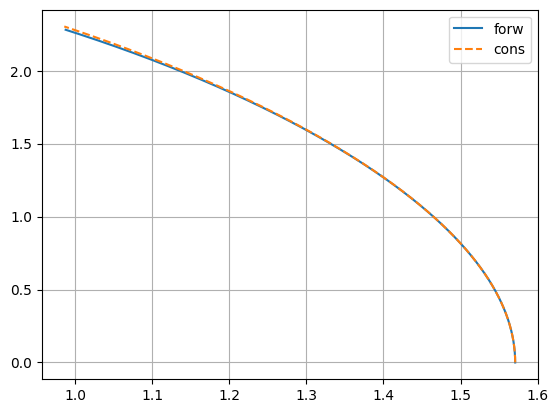

In [ ]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0,
)

init_state = np.array([np.pi/2, 0])
dt = 0.0001
N = 5000
poses_cons = [init_state]
poses_forw = [init_state]
for i in range(N):
    poses_cons.append(pendulum.step(poses_cons[-1], 1, -dt))
    poses_forw.append(pendulum.step(poses_forw[ 0], 1, -i*dt))

poses_cons = np.array(poses_cons)
poses_forw = np.array(poses_forw)


plt.plot(poses_forw[:, 0], poses_forw[:, 1], label='forw')
plt.plot(poses_cons[:, 0], poses_cons[:, 1], label='cons', linestyle='--')
plt.legend()
plt.grid()
